## All models

### Run

We have a single function for the step that carries out the whole process of detection, description, matching and drawing. The idea is to draw rectangular boxes around the baricenters of the found images, which shows more reliable boxes than a Homography. By the implementation of color consistency and overlap checking functions, we achieve satisfying results in the detection of almost all the boxes in the shelves. Mostly, the reason for undetected boxes is because they are not in the models. We can detect some boxes that are not in the models because they share similarities with other ones, however by changing the parameters we may filter those out too.

In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import skimage.morphology as sk
from math import cos,sin

def run(train_bgr,LOWE=0.8,MIN_COLOR_DISTANCE=120,PRECX=0.25,PRECY=0.25,MAXT=5,queries=[], boxes_color=(0,255,0)):

    sift = cv2.xfeatures2d.SIFT_create()
    bf = cv2.BFMatcher()

    train = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2GRAY)
    train_kp, train_des = sift.detectAndCompute(train, None)

    boxes = []
    
    for n_query,query in enumerate(queries):
        query_bgr = query
        query = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)
        query_kp, query_des = sift.detectAndCompute(query, None)
        query_c = np.mean([kp.pt for kp in query_kp],axis=0)

        all_matches = bf.knnMatch(train_des, query_des, k=2)

        good_matches = []

        for m, n in all_matches:
            if m.distance < LOWE * n.distance:
                good_matches.append(m)
                    

                # print good keypoints
                #plt.scatter(train_kp[m.queryIdx].pt[0],train_kp[m.queryIdx].pt[1],color='green',s=10)


        query_vectors = [query_c - query_kp[m.trainIdx].pt for m in good_matches]
        scales = [train_kp[m.queryIdx].size/query_kp[m.trainIdx].size for m in good_matches]
        baricenters = np.array([train_kp[m.queryIdx].pt+query_vectors[i] * scales[i] for i,m in enumerate(good_matches)])

        #print found baricenters
        #plt.scatter(baricenters[:,0],baricenters[:,1],color='red',s=10)

        counts_scale, bins_scale, patches_size = plt.hist([scales[i] for i,m in enumerate(good_matches)], bins='auto')

        img_scale = max(bins_scale[np.argmax(counts_scale)],0.001)

        x_bin_size = img_scale * query.shape[1] * PRECX
        y_bin_size = img_scale * query.shape[0] * PRECY
        x_bins = int(train.shape[1] // x_bin_size + 1)
        y_bins = int(train.shape[0] // y_bin_size + 1) # int approximation goes to the floor value , so + 1

        # print bins corners
        # for x in range(0,x_bins):
        #     for y in range(0,y_bins):
        #         plt.scatter(x*x_bin_size,y*y_bin_size,s=10,color='green')

        votes = {}
        accumulator=np.zeros((x_bins,y_bins))

        for i,b in enumerate(baricenters):
            b_bin = (int(b[0] // x_bin_size),int(b[1] // y_bin_size))
            if b_bin[0] < x_bins and b_bin[1] < y_bins and b_bin[0]>=0 and b_bin[1]>=0:
                accumulator[b_bin[0],b_bin[1]] += 1
                votes[b_bin] = votes.get(b_bin, [])
                votes[b_bin].append(good_matches[i])

        mask = sk.local_maxima(accumulator)
        accumulator[mask != True] = 0

        for i in np.argwhere(accumulator>=MAXT):

            matches = votes.get((i[0],i[1]),[])

            #color = list(np.random.random(size=3) * 256)

            # draw recognized bins
            # plt.scatter(i[0]*x_bin_size,i[1]*y_bin_size,c='blue',s=10)

            # draw recognized keypoints
            # for m in matches:
            #     train_rgb = cv2.circle(train_rgb, (int(kp[0]),int(kp[1])), radius=1, color=color, thickness=5)

            img_scale = np.mean([train_kp[m.queryIdx].size/query_kp[m.trainIdx].size for i,m in enumerate(matches)])

            query_baricenter = np.mean(np.array([query_kp[m.trainIdx].pt for i,m in enumerate(matches)]),axis=0)
            train_baricenter = np.mean(np.array([train_kp[m.queryIdx].pt for i,m in enumerate(matches)]),axis=0)
            b = train_baricenter - query_baricenter*img_scale
            h, w = query.shape
            
            height_train, width_train, _ = train_bgr.shape
            
            x_min = 0 + b[0]
            x_max = ((w - 1)*img_scale+b[0])
            y_min = 0+b[1]
            y_max = ((h - 1)*img_scale+b[1])
            
            pts = np.float32([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]]).reshape(-1,1,2)
            
            train_img_crop = train_bgr[max(int(y_min),0):min(int(y_max),height_train),
                                       max(int(x_min),0):min(int(x_max),width_train)]
            
            query_avg_color = query_bgr.reshape(-1,3).mean(axis=0)
            train_avg_color = train_img_crop.reshape(-1,3).mean(axis=0)
            color_distance = np.sqrt(sum(v ** 2 for v in (query_avg_color-train_avg_color)))
            
            if color_distance < MIN_COLOR_DISTANCE:
                boxes.append([pts,n_query])
    
    filtered_boxes = []
    queries_count = [0 for i in range(len(queries))]
    filtered_boxes_values = []
    
    for b,q in boxes:

        smallest = True
        center = [(b[0,0,0]+b[3,0,0])/2,(b[0,0,1]+b[1,0,1])/2]
        x_min = b[0,0,0]
        x_max = b[3,0,0]
        y_min = b[0,0,1]
        y_max = b[1,0,1]
        width = x_max - x_min
        height = y_max - y_min
        size = (x_max-x_min)*(y_max-y_min)
        for bb,qq in boxes:
            bb_center = [(bb[0,0,0]+bb[3,0,0])/2,(bb[0,0,1]+bb[1,0,1])/2]
            bb_x_min = bb[0,0,0]
            bb_x_max = bb[3,0,0]
            bb_y_min = bb[0,0,1]
            bb_y_max = bb[1,0,1]
            bb_size = (bb_x_max-bb_x_min)*(bb_y_max-bb_y_min)
            if (center[0] > bb_x_min and center[0] < bb_x_max\
                            and center[1] > bb_y_min and center[1] < bb_y_max)\
                            or (bb_center[0] > x_min and bb_center[0] < x_max\
                            and bb_center[1] > y_min and bb_center[1] < y_max):
                                if(bb_size<size):
                                    smallest=False
        if smallest:
            filtered_boxes.append(b)
            filtered_boxes_values.append([center,width,height,q])
            queries_count[q] += 1

    
    train_bgr_boxes = train_bgr.copy()
    train_rgb_boxes = cv2.cvtColor(train_bgr_boxes, cv2.COLOR_BGR2RGB)
    for i,b in enumerate(filtered_boxes):
        train_rgb_boxes = cv2.polylines(train_rgb_boxes, [np.int32(b)], True, boxes_color, 3, cv2.LINE_AA)
    for i,count in enumerate(queries_count):
        if (count != 0):
            print('Product',i,'found:',count,'times')
            for box in  filtered_boxes_values:
                if box[3] == i:
                    print('\tObject found at center:',(int(box[0][0]), int(box[0][1])),',width:',int(box[1]),'px, height:',int(box[2]),'px')
    
    return train_rgb_boxes


### Hard scenes detection

Loop that detects boxes for every hard train image.

Product 0 found: 0 times
Product 1 found: 1 times
	Object found at center: (485, 327) ,width: 55 px, height: 72 px
Product 2 found: 1 times
	Object found at center: (79, 116) ,width: 47 px, height: 70 px
Product 3 found: 3 times
	Object found at center: (246, 420) ,width: 61 px, height: 79 px
	Object found at center: (304, 423) ,width: 60 px, height: 77 px
	Object found at center: (361, 422) ,width: 59 px, height: 76 px
Product 4 found: 2 times
	Object found at center: (141, 129) ,width: 62 px, height: 99 px
	Object found at center: (203, 130) ,width: 64 px, height: 102 px
Product 5 found: 2 times
	Object found at center: (270, 123) ,width: 47 px, height: 71 px
	Object found at center: (332, 124) ,width: 45 px, height: 68 px
Product 6 found: 2 times
	Object found at center: (252, 326) ,width: 52 px, height: 76 px
	Object found at center: (311, 326) ,width: 53 px, height: 77 px
Product 7 found: 2 times
	Object found at center: (433, 242) ,width: 53 px, height: 84 px
	Object found at cen

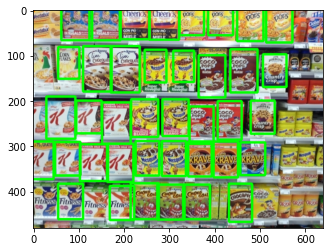

Product 0 found: 0 times
Product 1 found: 1 times
	Object found at center: (517, 310) ,width: 55 px, height: 72 px
Product 2 found: 2 times
	Object found at center: (35, 108) ,width: 62 px, height: 93 px
	Object found at center: (104, 109) ,width: 60 px, height: 91 px
Product 3 found: 2 times
	Object found at center: (277, 407) ,width: 61 px, height: 78 px
	Object found at center: (333, 408) ,width: 65 px, height: 83 px
Product 4 found: 2 times
	Object found at center: (167, 105) ,width: 65 px, height: 103 px
	Object found at center: (230, 106) ,width: 64 px, height: 102 px
Product 5 found: 2 times
	Object found at center: (304, 100) ,width: 51 px, height: 76 px
	Object found at center: (368, 100) ,width: 51 px, height: 76 px
Product 6 found: 0 times
Product 7 found: 0 times
Product 8 found: 4 times
	Object found at center: (431, 123) ,width: 64 px, height: 101 px
	Object found at center: (424, 228) ,width: 51 px, height: 80 px
	Object found at center: (482, 228) ,width: 50 px, height:

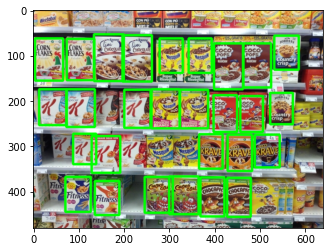

Product 0 found: 2 times
	Object found at center: (346, 310) ,width: 54 px, height: 73 px
	Object found at center: (404, 312) ,width: 54 px, height: 73 px
Product 1 found: 1 times
	Object found at center: (586, 315) ,width: 58 px, height: 76 px
Product 2 found: 2 times
	Object found at center: (32, 386) ,width: 44 px, height: 67 px
	Object found at center: (80, 387) ,width: 43 px, height: 64 px
Product 3 found: 3 times
	Object found at center: (341, 403) ,width: 58 px, height: 74 px
	Object found at center: (396, 407) ,width: 62 px, height: 79 px
	Object found at center: (454, 408) ,width: 61 px, height: 79 px
Product 4 found: 2 times
	Object found at center: (243, 120) ,width: 59 px, height: 93 px
	Object found at center: (301, 119) ,width: 61 px, height: 97 px
Product 5 found: 2 times
	Object found at center: (365, 111) ,width: 47 px, height: 71 px
	Object found at center: (426, 109) ,width: 49 px, height: 74 px
Product 6 found: 0 times
Product 7 found: 1 times
	Object found at cente

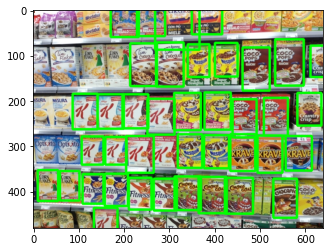

Product 0 found: 0 times
Product 1 found: 1 times
	Object found at center: (507, 334) ,width: 57 px, height: 75 px
Product 2 found: 2 times
	Object found at center: (13, 131) ,width: 66 px, height: 98 px
	Object found at center: (84, 131) ,width: 65 px, height: 97 px
Product 3 found: 2 times
	Object found at center: (267, 439) ,width: 63 px, height: 81 px
	Object found at center: (328, 439) ,width: 64 px, height: 82 px
Product 4 found: 2 times
	Object found at center: (150, 126) ,width: 67 px, height: 106 px
	Object found at center: (217, 128) ,width: 66 px, height: 105 px
Product 5 found: 2 times
	Object found at center: (289, 121) ,width: 50 px, height: 75 px
	Object found at center: (355, 121) ,width: 50 px, height: 75 px
Product 6 found: 1 times
	Object found at center: (326, 338) ,width: 54 px, height: 79 px
Product 7 found: 1 times
	Object found at center: (421, 130) ,width: 61 px, height: 99 px
Product 8 found: 3 times
	Object found at center: (398, 251) ,width: 52 px, height: 8

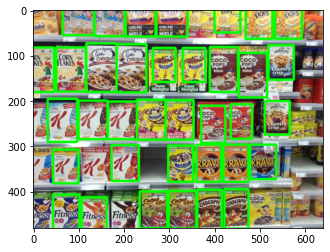

Product 0 found: 0 times
Product 1 found: 1 times
	Object found at center: (464, 338) ,width: 58 px, height: 76 px
Product 2 found: 1 times
	Object found at center: (32, 121) ,width: 52 px, height: 78 px
Product 3 found: 3 times
	Object found at center: (219, 439) ,width: 61 px, height: 79 px
	Object found at center: (278, 442) ,width: 61 px, height: 78 px
	Object found at center: (338, 441) ,width: 61 px, height: 79 px
Product 4 found: 2 times
	Object found at center: (101, 136) ,width: 69 px, height: 110 px
	Object found at center: (165, 135) ,width: 67 px, height: 106 px
Product 5 found: 3 times
	Object found at center: (220, 337) ,width: 52 px, height: 79 px
	Object found at center: (237, 127) ,width: 50 px, height: 76 px
	Object found at center: (303, 128) ,width: 48 px, height: 73 px
Product 6 found: 1 times
	Object found at center: (282, 339) ,width: 53 px, height: 77 px
Product 7 found: 1 times
	Object found at center: (369, 139) ,width: 68 px, height: 108 px
Product 8 found: 3

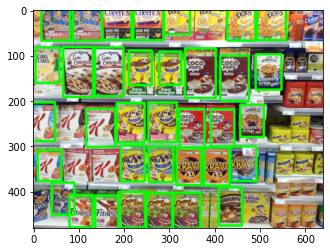

In [23]:
queries = []
for query in range(0,27):
    file = 'models/' + str(query) + '.jpg'
    query = cv2.imread(file)
    queries.append(query)
    

for f in ['scenes/h2.jpg','scenes/h1.jpg','scenes/h3.jpg','scenes/h4.jpg','scenes/h5.jpg']:

    file = f
    train_bgr = cv2.imread(file)
    
    train_rgb_boxes = run(train_bgr,MIN_COLOR_DISTANCE=70,LOWE=0.75,PRECX=0.25,PRECY=0.5,MAXT=5,queries = queries)
    plt.imshow(train_rgb_boxes)
    plt.show()

### Medium scenes detection (optional)

Our code still detects the correct boxes in the medium images, by the tuning of the MAXT parameter.

Product 1 found: 2 times
	Object found at center: (502, 735) ,width: 321 px, height: 420 px
	Object found at center: (834, 716) ,width: 303 px, height: 397 px
Product 11 found: 1 times
	Object found at center: (164, 714) ,width: 301 px, height: 446 px
Product 19 found: 1 times
	Object found at center: (910, 191) ,width: 295 px, height: 403 px
Product 25 found: 2 times
	Object found at center: (233, 236) ,width: 356 px, height: 478 px
	Object found at center: (569, 239) ,width: 346 px, height: 465 px


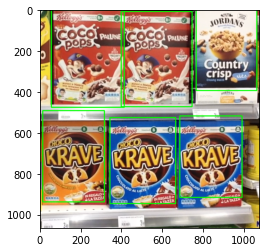

In [28]:
queries = []
for query in range(0,27):
    file = 'models/' + str(query) + '.jpg'
    query = cv2.imread(file)
    queries.append(query)
    

for f in ['scenes/m5.png']:

    file = f
    train_bgr = cv2.imread(file)
    
    train_rgb_boxes = run(train_bgr,MIN_COLOR_DISTANCE=40,LOWE=0.75,PRECX=0.25,PRECY=0.5,MAXT=50,queries = queries)
    plt.imshow(train_rgb_boxes)
    plt.show()